In [101]:
import numpy as np
from hyppo.ksample import MMD
from sparse_shift import KCD
from scipy.stats import wilcoxon
from sparse_shift.datasets import sample_topological
from sparse_shift.plotting import plot_dag
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Test structure

The function `test_structure` takes in observations from each setting and, given a DAG, uses KCD to assess how many conditional distributions change across the environments.

The function `get_triangle_dags` returns all DAGs on three variables.

Note that DAGs outside of the Markov equivalence class may yield unexpected numbers of changes. Given the true DAG G, 

In [102]:
def test_structure(Xs, parent_graph, reps=1000, n_jobs=None):
    """
    Tests pairwise mechanism equality
    
    Parameters
    ----------
    Xs : list of np.ndarray, shape (E, n_e, m)
        List of observations from each environment  
    parent_graph : np.ndarray, shape (m, m)
        Adjacency matrix indicating parents of each variable
    reps : int
        Number of permutations for the permutation test
        
    Returns
    -------
    - np.ndarray, shape (e, e, m)
        pvalues for each pairwise test
    """
    E = len(Xs)
    parent_graph = np.asarray(parent_graph)
    M = parent_graph.shape[0]
    conditional_pvalues = np.ones((M, E, E))
    marginal_pvalues = np.ones((M, E, E))
    
    for e1 in range(E):
        for e2 in range(e1+1, E):
            for m in range(M):
                parents = np.where(parent_graph[m] != 0)[0]
                if len(parents) == 0:
                    stat, pvalue = MMD().test(
                        Xs[e1][:, m], Xs[e2][:, m],
                        reps=reps, workers=n_jobs)
                else:
                    stat, pvalue = KCD(n_jobs=n_jobs).test(
                        np.vstack((Xs[e1][:, parents], Xs[e2][:, parents])),
                        np.concatenate((Xs[e1][:, m], Xs[e2][:, m])),
                        np.asarray([0]*Xs[e1].shape[0] + [1]*Xs[e2].shape[0]),
                        reps=reps,
                    )
                conditional_pvalues[m, e1, e2] = pvalue
                conditional_pvalues[m, e2, e1] = pvalue
                
    return conditional_pvalues


def get_triangle_dags():
    """Gets all graphs on 3 variables"""
    dags = []
    for e1 in [-1, 0, 1]: #x1 - x2
        for e2 in [-1, 0, 1]: # x2 - x3
            for e3 in [-1, 0, 1]: # x3 - x1
                # skip if cyclic
                if np.abs(np.sum([e1, e2, e3])) == 3:
                    continue
                # add edges
                dag = np.asarray([[0,  0, 0], [0, 0, 0], [0, 0 ,0]])
                for i, e in enumerate([e1, e2, e3]):
                    if e == 1: # X -> Y
                        dag[i, (i+1)%3] = 1
                    elif e == -1: # X <- Y
                        dag[(i+1)%3, i] = 1
                dags.append(dag)
    return dags

In [103]:
tri_dags = get_triangle_dags()
print(len(tri_dags)) # verify equals 25

25


## 3 variable SCM

In [5]:
# X1 -> X2, X1->X3, X2->X3
true_parents = np.asarray([[0,  0, 0], [1, 0, 0], [1, 1 ,0]])
n = 100

g1_noise = lambda: np.abs(np.random.standard_t(df=100))
g1_equations = [
    lambda X, U: U,
    lambda X, U: X[0] + U,
    lambda X, U: X[0] + X[1] + U,
]
g2_equations = [
    lambda X, U: U,
    lambda X, U: np.sin(2*np.pi*X[0]) + U,
    lambda X, U: X[0] + X[1] + U,
]

# 2 settings, X2|X1 changes
Xs = [
    sample_topological(n, g1_equations, g1_noise, random_state=1),
    sample_topological(n, g2_equations, g1_noise, random_state=2),
]

In [11]:
len(Xs)

2

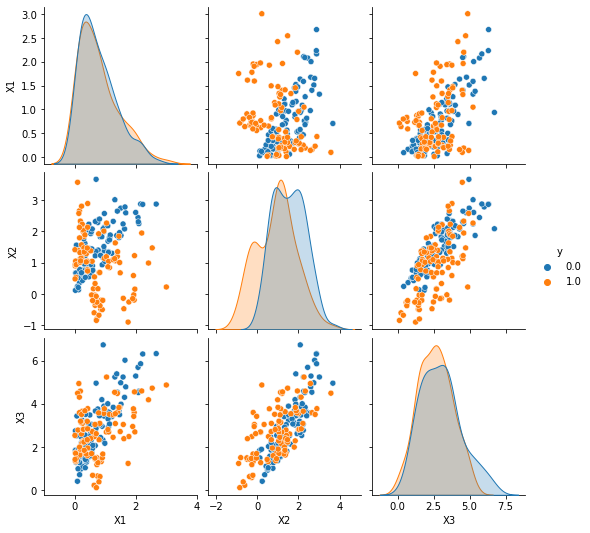

In [16]:
df = pd.DataFrame(
    np.hstack((
        np.vstack(Xs),
        np.hstack([[i]*X.shape[0] for i, X in enumerate(Xs)]).reshape(-1, 1).astype(int)
    )),
    columns=[f'X{i+1}' for i in range(Xs[0].shape[1])] + ['y']
)
sns.pairplot(df, hue='y')
plt.show()

In [17]:
pvalues_mat = test_structure(Xs, true_parents, reps=100, n_jobs=-2)

In [18]:
print(pvalues_mat)

[[[1.         1.        ]
  [1.         1.        ]]

 [[1.         0.00990099]
  [0.00990099 1.        ]]

 [[1.         0.66336634]
  [0.66336634 1.        ]]]


In [19]:
alpha = 0.05
print(np.sum(pvalues_mat <= alpha) // 2)

1


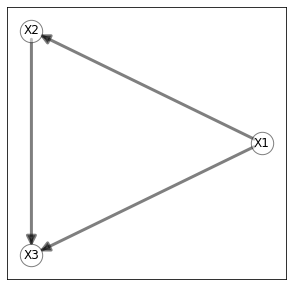

In [92]:
plot_dag(true_parents)

In [21]:
pval_mats = []
n_changes = []
for dag in tri_dags:
    print('.', end='')
    pvalues_mat = test_structure(Xs, dag, reps=100, n_jobs=-2)
    pval_mats.append(pvalues_mat)
    n_changes.append(np.sum(pvalues_mat <= alpha) // 2) # Number of changing mechanisms in DAG
pval_mats = np.asarray(pval_mats)
n_changes = np.asarray(n_changes)

.........................

In [61]:
print('Number of changes (all DAGs): ', n_changes)
print('Number of changes (MEC): ', n_changes[np.sum(tri_dags, axis=(1, 2)) == 3])

Number of changes (all DAGs):  [1 1 1 1 2 1 1 2 1 1 1 1 1 2 0 0 1 2 1 1 2 1 2 1 0]
Number of changes (MEC):  [1 1 2 2 1 1]


0 changes, not in MEC


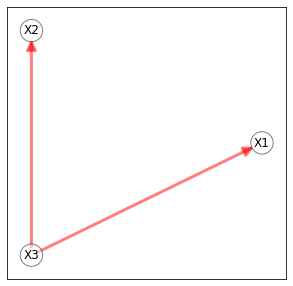

In [96]:
print('0 changes, not in MEC')
idx = np.where(n_changes == 0)[0][0]
false_dag = tri_dags[idx]
plot_dag(false_dag, highlight_edges=false_dag-true_parents, highlight_nodes=(pval_mats[idx][:, 0, 1] < alpha))

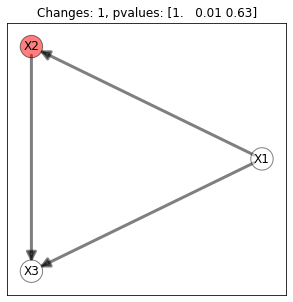

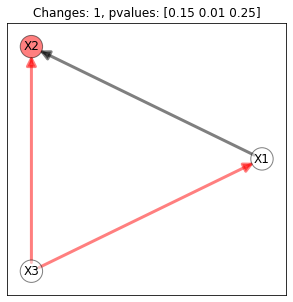

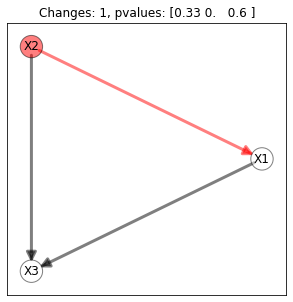

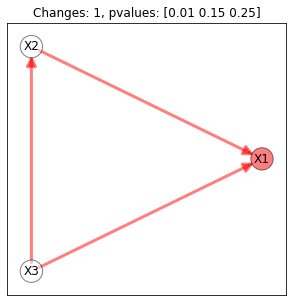

In [99]:
for dag, nch, pvals in zip(tri_dags, n_changes, pval_mats):
    if nch == 1 and dag.sum() == 3:
        plot_dag(
            dag,
            highlight_edges=dag-true_parents,
            highlight_nodes=(pvals[:, 0, 1] < alpha),
            title=f'Changes: {nch}, pvalues: {np.round(pvals, 2)[:, 0, 1]}')

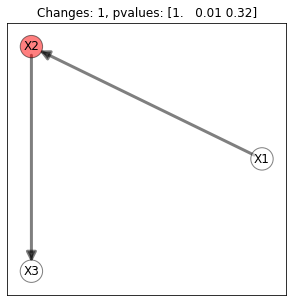

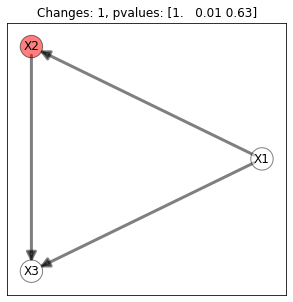

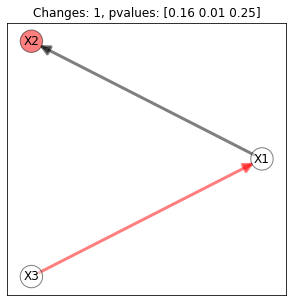

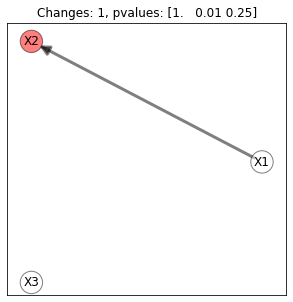

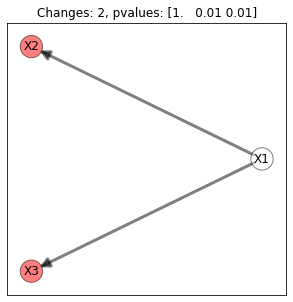

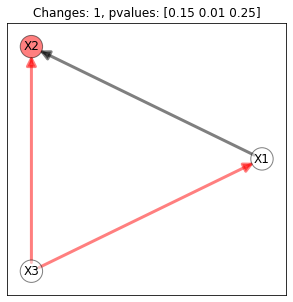

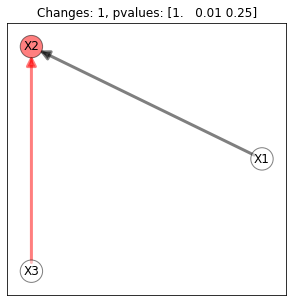

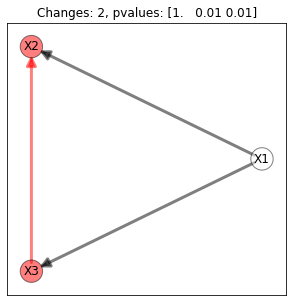

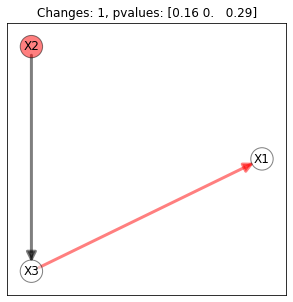

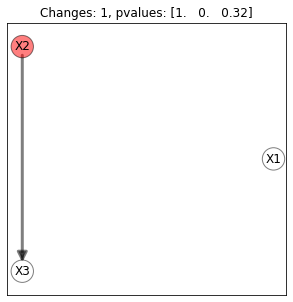

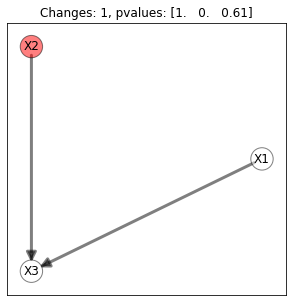

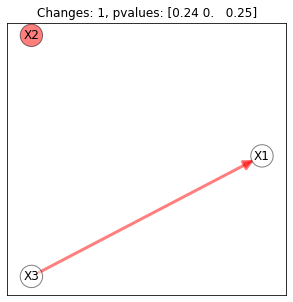

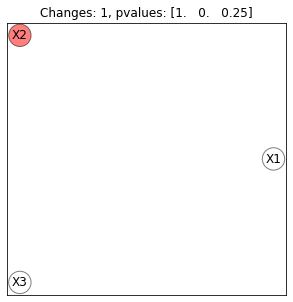

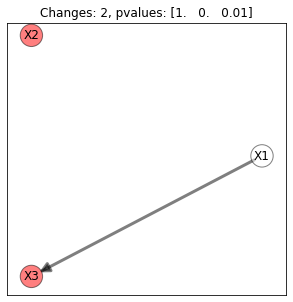

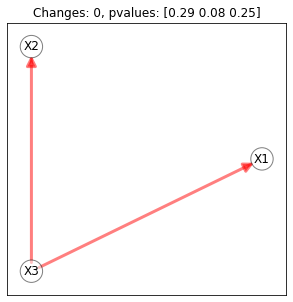

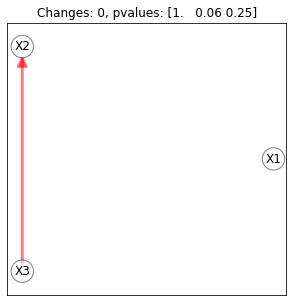

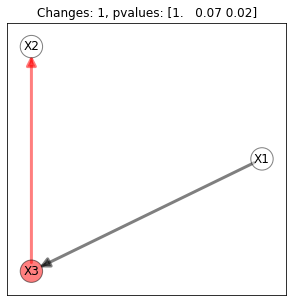

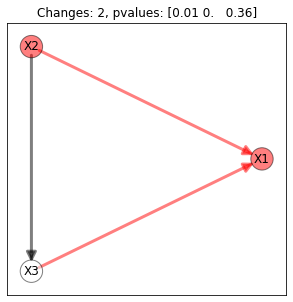

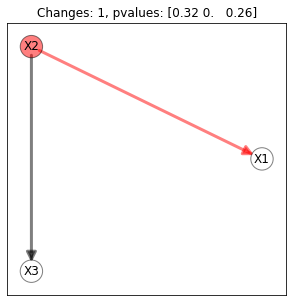

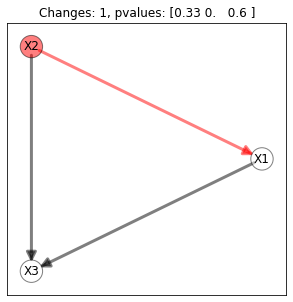

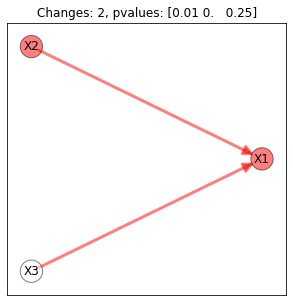

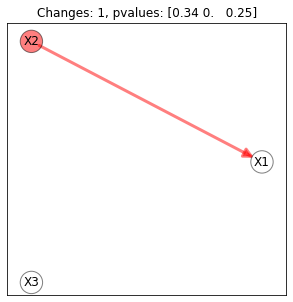

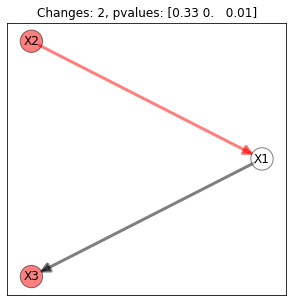

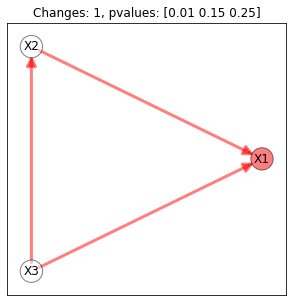

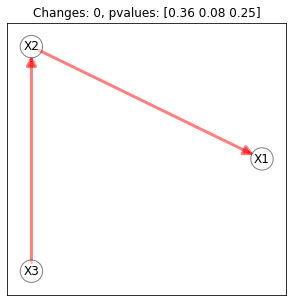

In [100]:
for dag, nch, pvals in zip(tri_dags, n_changes, pval_mats):
    plot_dag(
        dag,
        highlight_edges=dag-true_parents,
        highlight_nodes=(pvals[:, 0, 1] < alpha),
        title=f'Changes: {nch}, pvalues: {np.round(pvals, 2)[:, 0, 1]}')